# Comparing three methods (average, weighted average, and weighted average with covariance correction) for calculating LogPsfKronRatio 

To examine which method for calculating LogPsfRatio provides good value for separating star and galaxy, I check ROC AUC score for these three methods. 

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
hst_ps1 = pd.read_csv('HST_PS1_stack_tachibana.csv')
cat = hst_ps1.drop_duplicates(['objID'])
del hst_ps1

In [45]:
star, galaxy = cat.MU_CLASS == 2, cat.MU_CLASS == 1
mag_mask = cat.MAG_AUTO <= 24.5
star = star&mag_mask; galaxy = galaxy&mag_mask

In [46]:
def calc_psfKronRatio(catalog, correct_cov=True, weighted=True):
    filter_name =  ['g', 'r', 'i', 'z', 'y']
    psfmag_name = 'PSFMag'
    kronmag_name = 'KronMag'
    psfmagerr_name = 'PSFMagErr'
    kronmagerr_name = 'KronMagErr'
    psfmag_list = []
    kronmag_list = []
    psfmagerr_list = []
    kronmagerr_list = []
    for fil in filter_name:
        psfmag_list.append(fil+psfmag_name)
        kronmag_list.append(fil+kronmag_name)
        psfmagerr_list.append(fil+psfmagerr_name)
        kronmagerr_list.append(fil+kronmagerr_name)
    mag_list = psfmag_list + kronmag_list + psfmagerr_list + kronmagerr_list
    PS_mag = cat[mag_list]
    weight_norm = np.zeros(len(PS_mag))
    det_num = np.zeros(len(PS_mag))
    mean_mag_diff_w =np.zeros(len(PS_mag))
    mean_mag_differr_w =np.zeros(len(PS_mag))

    for fil in filter_name:
        psf_col_name = fil + psfmag_name
        kron_col_name = fil + kronmag_name
        psferr_col_name = fil + psfmagerr_name
        kronerr_col_name = fil + kronmagerr_name
        
        det_mask = (PS_mag[psf_col_name].values != -999)&(PS_mag[kron_col_name].values != -999)
        
        PsfKronDiffMag = np.add(-PS_mag[psf_col_name].values, PS_mag[kron_col_name].values,
                                                  out = np.zeros_like(mean_mag_diff_w),
                                                  where = det_mask)/2.5
        
        if correct_cov:
            ErrCorCoef = np.corrcoef(PS_mag[psferr_col_name][det_mask].values, 
                                    PS_mag[kronerr_col_name][det_mask].values)[0,1]
        else: 
            ErrCorCoef = 0                
        
        PsfKronDiffMagErr = np.sqrt( PS_mag[psferr_col_name].values**2 +
                                   PS_mag[kronerr_col_name].values**2 -
                                   2*ErrCorCoef*PS_mag[psferr_col_name].values*PS_mag[kronerr_col_name].values)

        if weighted:
            weight = np.divide(1, PsfKronDiffMagErr**2, 
                                                      out = np.zeros_like(mean_mag_diff_w), 
                                                      where = det_mask)
        else:
            weight = np.zeros(len(mean_mag_diff_w))
            weight[det_mask] = 1

        PsfKronDiffMag_w = np.multiply(PsfKronDiffMag, weight, 
                                                  out = np.zeros_like(mean_mag_diff_w), 
                                                  where = det_mask)

        PsfKronDiffMagErr_w = np.multiply(PsfKronDiffMagErr, weight, 
                                                  out = np.zeros_like(mean_mag_diff_w), 
                                                  where = det_mask)

        mean_mag_diff_w += PsfKronDiffMag_w
        mean_mag_differr_w += PsfKronDiffMagErr_w
        weight_norm += weight
        det_num += det_mask.astype(int)

    mask = (mean_mag_diff_w != 0)&(weight_norm != 0)
    mean_mag_diff = np.divide(mean_mag_diff_w, weight_norm, 
                             out = np.zeros_like(mean_mag_diff_w), 
                             where = mask)
    mean_mag_differr = np.divide(mean_mag_differr_w, weight_norm*np.sqrt(det_num), 
                             out = np.zeros_like(mean_mag_diff_w), 
                             where = mask)
    
    diff_kwargs = {'mean_psfKronDiff' : mean_mag_diff}
    differr_kwargs = {'mean_psfKronDifferr' : mean_mag_differr}
    PS_mag = PS_mag.assign(**diff_kwargs); PS_mag = PS_mag.assign(**differr_kwargs)
    return PS_mag

PS_mag: Average of KronMag $-$ PsfMag

PS_mag_w: Average of KronMag $-$ PsfMag weighted by error in KronMag and PsfMag

PS_mag_w_c: Average of KronMag $-$ PsfMag weighted by error in KronMag and PsfMag and corrected the effect from covariance in these error 

In [47]:
PS_mag = calc_psfKronRatio(cat, correct_cov=False, weighted=False)
PS_mag_w = calc_psfKronRatio(cat, correct_cov=False, weighted=True)
PS_mag_w_c = calc_psfKronRatio(cat, correct_cov=True, weighted=True)

rdet_mask = (PS_mag.rKronMag!=-999)&(PS_mag.mean_psfKronDiff!=0)&(PS_mag.mean_psfKronDiff!=0)
star = star&rdet_mask; galaxy=galaxy&rdet_mask

GT = np.ones(len(PS_mag))
GT[galaxy] = 0

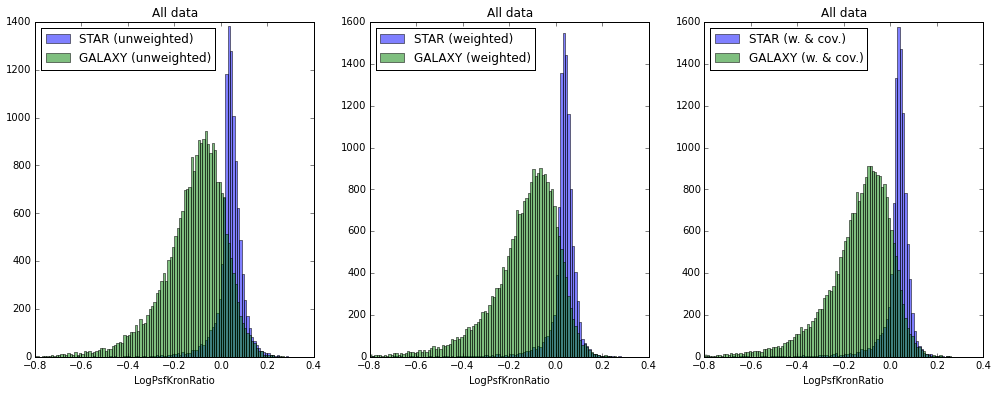

Overall ROC AUC score of (1) average, (2) weighted average, and (3) weighted average with covariance correction is 

(1) 0.8842, (2) 0.8925, and (3)0.8993 respectively. 


In [48]:
bins = np.arange(-0.8, 0.3, 0.01)
plt.figure(figsize=(17,6))
plt.subplot(1,3,1)
plt.hist(np.array(PS_mag.mean_psfKronDiff[star]), bins=bins, alpha=0.5, label='STAR (unweighted)')
plt.hist(np.array(PS_mag.mean_psfKronDiff[galaxy]), bins=bins, alpha=0.5, label='GALAXY (unweighted)')
plt.title('All data'); plt.xlabel('LogPsfKronRatio')
plt.legend(loc='upper left')

plt.subplot(1,3,2)
plt.hist(np.array(PS_mag_w.mean_psfKronDiff[star]), bins=bins, alpha=0.5, label='STAR (weighted)')
plt.hist(np.array(PS_mag_w.mean_psfKronDiff[galaxy]), bins=bins, alpha=0.5, label='GALAXY (weighted)')
plt.title('All data'); plt.xlabel('LogPsfKronRatio')
plt.legend(loc='upper left')

plt.subplot(1,3,3)
plt.hist(np.array(PS_mag_w_c.mean_psfKronDiff[star]), bins=bins, alpha=0.5, label='STAR (w. & cov.)')
plt.hist(np.array(PS_mag_w_c.mean_psfKronDiff[galaxy]), bins=bins, alpha=0.5, label='GALAXY (w. & cov.)')
plt.title('All data'); plt.xlabel('LogPsfKronRatio')
plt.legend(loc='upper left')
plt.show()

roc = roc_auc_score(GT[star|galaxy], PS_mag.mean_psfKronDiff[star|galaxy])
roc_w = roc_auc_score(GT[star|galaxy], PS_mag_w.mean_psfKronDiff[star|galaxy])
roc_w_c = roc_auc_score(GT[star|galaxy], PS_mag_w_c.mean_psfKronDiff[star|galaxy])

print """Overall ROC AUC score of (1) average, (2) weighted average, and (3) weighted average with covariance correction is \n
(1) %1.4f, (2) %1.4f, and (3)%1.4f respectively. """ %(roc, roc_w, roc_w_c)

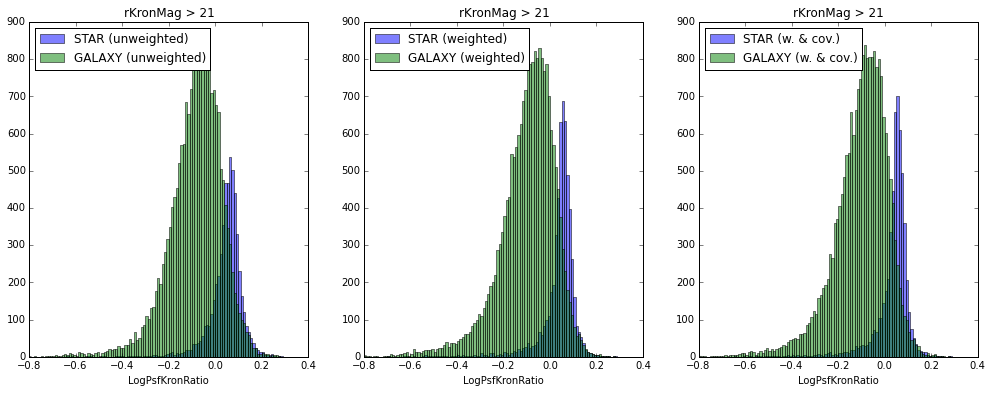

ROC AUC score of (1) average, (2) weighted average, and (3) weighted average with covariance correction is 

(1) 0.8674, (2) 0.8760, and (3)0.8778 respectively for sources in rKronMag > 21. 


In [52]:
mag_mask = (PS_mag.rKronMag>=21)

plt.figure(figsize=(17,6))
plt.subplot(1,3,1)
plt.hist(np.array(PS_mag.mean_psfKronDiff[star&mag_mask]), bins=bins, alpha=0.5, label='STAR (unweighted)')
plt.hist(np.array(PS_mag.mean_psfKronDiff[galaxy&mag_mask]), bins=bins, alpha=0.5, label='GALAXY (unweighted)')
plt.title('rKronMag > 21'); plt.xlabel('LogPsfKronRatio')
plt.legend(loc='upper left')

plt.subplot(1,3,2)
plt.hist(np.array(PS_mag_w.mean_psfKronDiff[star&mag_mask]), bins=bins, alpha=0.5, label='STAR (weighted)')
plt.hist(np.array(PS_mag_w.mean_psfKronDiff[galaxy&mag_mask]), bins=bins, alpha=0.5, label='GALAXY (weighted)')
plt.title('rKronMag > 21'); plt.xlabel('LogPsfKronRatio')
plt.legend(loc='upper left')

plt.subplot(1,3,3)
plt.hist(np.array(PS_mag_w_c.mean_psfKronDiff[star&mag_mask]), bins=bins, alpha=0.5, label='STAR (w. & cov.)')
plt.hist(np.array(PS_mag_w_c.mean_psfKronDiff[galaxy&mag_mask]), bins=bins, alpha=0.5, label='GALAXY (w. & cov.)')
plt.title('rKronMag > 21'); plt.xlabel('LogPsfKronRatio')
plt.legend(loc='upper left')
plt.show()

roc = roc_auc_score(GT[(star|galaxy)&mag_mask], PS_mag.mean_psfKronDiff[(star|galaxy)&mag_mask])
roc_w = roc_auc_score(GT[(star|galaxy)&mag_mask], PS_mag_w.mean_psfKronDiff[(star|galaxy)&mag_mask])
roc_w_c = roc_auc_score(GT[(star|galaxy)&mag_mask], PS_mag_w_c.mean_psfKronDiff[(star|galaxy)&mag_mask])

print """ROC AUC score of (1) average, (2) weighted average, and (3) weighted average with covariance correction is \n
(1) %1.4f, (2) %1.4f, and (3)%1.4f respectively for sources in rKronMag > 21. """ %(roc, roc_w, roc_w_c)

This result suggests we should correct the effect from covariance in error in KronMag and PsfMag. 